In [ ]:
# default_exp splots

In [ ]:
#hide_input
from pivotpy.utils import nav_links 
nav_links(2)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` Example&nbsp;](https://massgh.github.io/pivotpy/Example)  
> [&nbsp;`▶` StaticPlots●&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` SpinProjectedSurfaces&nbsp;](https://massgh.github.io/pivotpy/SpinProjectedSurfaces)  
> [&nbsp;`▶` StructureIO&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  


# Static Plots
> All types of plots in matplotlib are included in this module. This includes bands,DOS and other general plots, which can be saved as pdf,png,jpg and other formats that matplotlib offers.

## Passing Large Number of Arguments as a Dictionary
- Let's take example of `splot_bands`. It requires a lot of arguments and most of them are default, but in order to tweak parameters, you still need to access them. Follow These steps to input arguments easily.
- In code cell, write `splot_bands?` and hit enter. This will give Signature and DocString.
- Copy arguments and pass to a dictionary `dict(what you copied)`. In a Jupyter Notebook cell, you can edit it:

In [ ]:
arg_dict=dict(
    path_evr=None,
    ax=None,
    skipk=None,
    kseg_inds=[],
    elim=[],
    ktick_inds=[],
    ktick_vals=[],
    E_Fermi=None
)
arg_dict

{'path_evr': None,
 'ax': None,
 'skipk': None,
 'kseg_inds': [],
 'elim': [],
 'ktick_inds': [],
 'ktick_vals': [],
 'E_Fermi': None}

- As you can see, I deleted few unnecessary arguments. Now you can use dictionary unpacking operator `**` inside function, it will pass all arguments present in dictionary. Make sure you do not change name of variables, although you can delete as few of them.
- **Usage:** Call function as `splot_bands(**arg_dict)`, it is usful if you run a function with same arguments many times.

In [ ]:
#export
import os
import numpy as np
from io import BytesIO
import PIL #For text image.
from collections import namedtuple
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSC
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Inside packages import to work both with package and jupyter notebook.
try:
    from pivotpy import parser as vp
    from pivotpy import utils as gu
    from pivotpy import serializer
except:
    import pivotpy.parser as vp
    import pivotpy.utils as gu
    import pivotpy.serializer as serializer

from IPython import get_ipython
from IPython.display import HTML, set_matplotlib_formats #HTML for plt2html

# print SVG in ipython
try:
    shell = get_ipython().__class__.__name__
    if shell == 'ZMQInteractiveShell' or shell == 'Shell': # Shell for colab.
        set_matplotlib_formats('svg')
except: pass # Not in terminal

# Gloabal settings matplotlib
mpl.rcParams['axes.linewidth'] = 0.4 #set the value globally
mpl.rcParams['font.serif'] = "STIXGeneral"
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['mathtext.fontset'] = "stix"

## Customize Matplotlib's Figure

In [ ]:
#export
def modify_axes(ax=None,xticks=[],xt_labels=[],xlim=[],\
            yticks=[],yt_labels=[],ylim=[],xlabel=None,ylabel=None,\
            vlines=True,zeroline=True):
    """
    - Returns None, applies given settings on axes. Prefered to use before other plotting.
    - **Parameters**
        - ax  : Matplotlib axes object.
        - (x,y)ticks : List of positions on (x,y axes).
        - (xt,yt)_labels : List of labels on (x,y) ticks points.
        - (x,y)lim : [min, max] of (x,y) axes.
        - (x,y)label : axes labels.
        - vlines : If true, drawn when `ylim` is not empty.
        - zeroline : If True, drawn when `xlim` is not empty.
    """
    if ax==None:
        raise ValueError("Matplotlib axes (ax) is not given.")
    else:
        if xticks:
            ax.set_xticks(xticks)
            ax.set_xticklabels(xt_labels if xt_labels else list(map(str,xticks)))
        if yticks:
            ax.set_yticks(yticks)
            ax.set_yticklabels(yt_labels if yt_labels else list(map(str,yticks)))
        if xlim:
            ax.set_xlim(xlim)
            if zeroline:
                ax.hlines(0,min(xlim),max(xlim),color=(0,0,0,0.6), linestyle='dashed',lw=0.3)
        if ylim:
            ax.set_ylim(ylim)
            if vlines:
                ax.xaxis.grid(color=(0,0,0,0.6), linestyle='dashed',lw=0.3)
        if xlabel!=None:
            ax.set_xlabel(xlabel)
        if ylabel!=None:
            ax.set_ylabel(ylabel)
        ax.tick_params(direction='in', top=True,bottom=True,left=True,right=True,length=4, width=0.3, grid_alpha=0.8)
    return None

In [ ]:
#export
def get_axes(figsize  = (3.4,2.6),
            nrows     = 1,
            ncols     = 1,
            widths    = [],
            heights   = [],
            axes_off  = [],
            axes_3d   = [],
            sharex    = False,
            sharey    = False,
            azim      = 45,
            elev      = 15,
            ortho3d   = True,
            **subplots_adjust_kwargs
            ):
    """
    - Returns flatten axes of initialized figure, based on plt.subplots(). If you want to access parent figure, use ax.get_figure() or current figure as plt.gcf().
    - **Parameters**
        - figsize   : Tuple (width, height). Default is (3.4,2.6).
        - nrows     : Default 1.
        - ncols     : Default 1.
        - widths    : List with len(widths)==nrows, to set width ratios of subplots.
        - heights   : List with len(heights)==ncols, to set height ratios of subplots.
        - share(x,y): Share axes between plots, this removes shared ticks automatically.
        - axes_off  : Turn off axes visibility, If `nrows = ncols = 1, set True/False`, If anyone of `nrows or ncols > 1`, provide list of axes indices to turn off. If both `nrows and ncols > 1`, provide list of tuples (x_index,y_index) of axes.
        - axes_3d   : Change axes to 3D. If `nrows = ncols = 1, set True/False`, If anyone of `nrows or ncols > 1`, provide list of axes indices to turn off. If both `nrows and ncols > 1`, provide list of tuples (x_index,y_index) of axes.
        - azim,elev   : Matplotlib's 3D angles, defualt are 45,15.
        - ortho3d     : Only works for 3D axes. If True, x,y,z are orthogonal, otherwise perspective.
        - **subplots_adjust_kwargs : These are same as `plt.subplots_adjust()`'s arguements.
    """
    # SVG and rcParams are must in get_axes to bring to other files, not just here.
    # print SVG in ipython
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell' or shell == 'Shell': # Shell for colab.
            set_matplotlib_formats('svg')
    except: pass # Not in terminal

    # Gloabal settings matplotlib, inside figure as well
    mpl.rcParams['axes.linewidth'] = 0.4 #set the value globally
    mpl.rcParams['font.serif'] = "STIXGeneral"
    mpl.rcParams['font.family'] = "serif"
    mpl.rcParams['mathtext.fontset'] = "stix"

    if figsize[0] <= 2.38:
        mpl.rc('font', size=8)
    gs_kw=dict({}) # Define Empty Dictionary.
    if widths!=[] and len(widths)==ncols:
        gs_kw=dict({**gs_kw,'width_ratios':widths})
    if heights!=[] and len(heights)==nrows:
        gs_kw = dict({**gs_kw,'height_ratios':heights})
    fig, axs = plt.subplots(nrows,ncols,figsize=figsize,gridspec_kw=gs_kw,sharex=sharex,sharey=sharey)
    proj = {'proj_type':'ortho'} if ortho3d else {} # For 3D only
    if nrows*ncols==1:
        modify_axes(ax=axs)
        if axes_off == True:
            axs.set_axis_off()
        if axes_3d == True:
            pos = axs.get_position()
            axs.remove()
            axs = fig.add_axes(pos,projection='3d',azim=azim,elev=elev,**proj)
            setattr(axs,add_legend.__name__,add_legend.__get__(axs,type(axs)))

    else:
        _ = [modify_axes(ax=ax) for ax in axs.ravel()]
        _ = [axs[inds].set_axis_off() for inds in axes_off if axes_off!=[]]
        if axes_3d != []:
            for inds in axes_3d:
                pos = axs[inds].get_position()
                axs[inds].remove()
                axs[inds] = fig.add_axes(pos,projection='3d',azim=azim,elev=elev,**proj)
    try:
        for ax in np.array([axs]).flatten():
            for f in [add_text,add_legend,add_colorbar,color_wheel,color_cube, break_spines,modify_axes,append_axes]:
                if ax.name != '3d':
                    setattr(ax,f.__name__,f.__get__(ax,type(ax)))
    except: pass

    plt.subplots_adjust(**subplots_adjust_kwargs)

    return axs

def append_axes(ax,position='right',size=0.2,pad=0.1,sharex=False,sharey=False,**kwargs):
    """
    Append an axes to the given `ax` at given `position` |top|right|left|bottom|. Useful for adding custom colorbar.
    kwargs are passed to `mpl_toolkits.axes_grid1.make_axes_locatable.append_axes`.
    Returns appended axes.
    """
    extra_args = dict(add_to_figure=True)
    if sharex:
        extra_args['sharex'] = ax
    if sharey:
        extra_args['sharey'] = ax
    divider = make_axes_locatable(ax)
    added_ax = divider.append_axes(position=position, size=size, pad=pad, **extra_args, **kwargs)
    _ = modify_axes(ax=added_ax) # tweaks of styles
    return added_ax

def join_axes(ax1,ax2, **kwargs):
    """Join two axes together. Useful for adding custom colorbar on a long left axes of whole figure.
    Apply tight_layout() before calling this function.
    kwargs are passed to `fig.add_axes`.
    """
    p1 = ax1.get_position()
    p2 = ax2.get_position()
    x0 = min(p1.x0,p2.x0)
    y0 = min(p1.y0,p2.y0)
    x1 = max(p1.x1,p2.x1)
    y1 = max(p1.y1,p2.y1)
    new_bbox = [x0,y0, x1-x0,y1-y0]
    fig = ax1.get_figure()
    ax1.remove()
    ax2.remove()
    new_ax = fig.add_axes(new_bbox, **kwargs)
    _ = modify_axes(new_ax)
    for f in [add_text,add_legend,add_colorbar,color_wheel,break_spines,modify_axes,append_axes]:
        if new_ax.name != '3d':
            setattr(new_ax,f.__name__,f.__get__(new_ax,type(new_ax)))
    return new_ax

### Tweaking `get_axes` by using `gridspec`. 
- This is a powerful way yo include any type of grid. For this, first use `gs = axs[0,0].get_gridspec()` and then remove axes you want to replace for another shape, then add required axis by `plt.gcf().add_subplot(gs[x_ind, y_ind])`. This process is illustrated in below examples.
- **Examples**
    - Axes remain same, just widths and height ratios are chnaged.


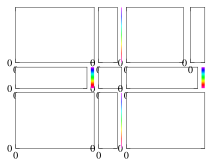

In [ ]:
#First Figure
import pivotpy.splots as sp 
axs = sp.get_axes(figsize=(3.4,2.6),ncols=3,widths=[3.4,1,3.4],nrows=3,heights=[2.6,1,2.6],wspace=0.076,hspace=0.1)
[sp.modify_axes(ax=ax,xticks=[0],yticks=[0]) for ax in axs.ravel()]
[sp.add_colorbar(ax=ax,ticks=[]) for ax in [axs[1,0],axs[1,2]]];
_ = [sp.add_colorbar(ax=ax,vertical=True,ticks=[]) for ax in [axs[0,1],axs[2,1]]]
_ = append_axes(axs[0,2],sharey=True,sharex=True)


- Here we will join two axes and regenerate new axes based on our grid choice.

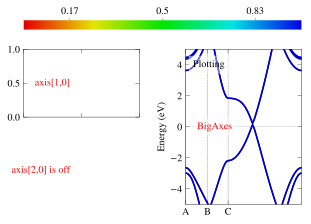

In [ ]:
#Second Figure
axs=get_axes(figsize=(5,3.4),nrows=3,ncols=2,widths=[1,1],heights=[1,7,7],wspace=0.4,hspace=0.4,axes_off=[(2,0)],sharex=True,sharey=True)
import pivotpy.splots as sp 
import matplotlib.pyplot as plt

axlarge = sp.join_axes(axs[0,0],axs[0,1])
axv = sp.join_axes(axs[1,1],axs[2,1])

sp.add_colorbar(ax=axv,cax=axlarge,vertical=False,cmap_or_clist='RGB')
sp.add_text(ax=axs[1,0],txts='axis[1,0]',xs=0.25,ys=0.5)
sp.add_text(ax=axs[2,0],txts='axis[2,0] is off',xs=0.15,ys=0.5)
import pivotpy.parser as vp 
vr=vp.export_vasprun(path='E:/Research/graphene_example/ISPIN_1/bands/vasprun.xml')
sp.splot_bands(path_evr=vr,ax=axv,txt='Plotting',E_Fermi=-3,ktick_inds=[0,15,30],ktick_vals=['A','B','C'])
sp.add_text(ax=axv,txts='BigAxes',xs=0.25,ys=0.5)
modify_axes(axv,vlines=True,ylim=[-5,5])

- A minial example below shows deleting an axes and then adding a 3D axes with same dimensions.

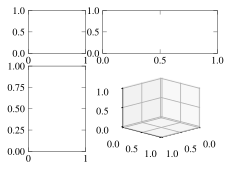

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
import pivotpy as pp 
ax = get_axes(nrows=2,ncols=2,widths=[1,2],heights=[1,2],axes_3d=[(1,1)])

## Broken Axes Plots
Sometimes we need to display different ranges of data scattered far apart. Use fubction `break_spines` defined below and see an example.

In [ ]:
#export
def break_spines(ax,spines,symbol=u'\u2571',**kwargs):
    """Simulates broken axes using subplots. Need to fix heights according to given data for real aspect. Also plot the same data on each axes and set axes limits.
    - **Parameters**
        - ax : Axes who's spine(s) to edit.
        - spines: str,list, str/list of any of ['top','bottom','left','right'].
        - symbol: Defult is u'\u2571'. Its at 60 degrees. so you can apply rotation to make it any angle.
    kwargs are passed to plt.text.
    """
    kwargs.update(transform=ax.transAxes, ha='center',va = 'center')
    _spines = [spines] if isinstance(spines,str) else spines
    _ = [ax.spines[s].set_visible(False) for s in _spines]
    ax.tick_params(**{sp:False for sp in _spines})
    if 'top' in spines:
        ax.text(0,1,symbol,**kwargs)
        ax.text(1,1,symbol,**kwargs)
    if 'bottom' in spines:
        ax.set_xticks([])
        ax.text(0,0,symbol,**kwargs)
        ax.text(1,0,symbol,**kwargs)
    if 'left' in spines:
        ax.set_yticks([])
        ax.text(0,0,symbol,**kwargs)
        ax.text(0,1,symbol,**kwargs)
    if 'right' in spines:
        ax.text(1,1,symbol,**kwargs)
        ax.text(1,0,symbol,**kwargs)

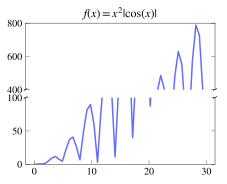

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
x = np.linspace(0,30,50)
y = x**2*np.abs(np.cos(x))
a1, a2 = get_axes(nrows=2)
a1.plot(x,y)
a2.plot(x,y)
# Set limits of data same as height_ratios to make visual correct
a2.set_ylim([0,100])
a1.set_ylim([400,800])
plt.subplots_adjust(hspace=0.12)
break_spines(a1,'bottom','~',rotation=35)
break_spines(a2,['top'],'~',rotation=35)
_ = a1.set_title('$f(x) = x^2|\cos(x)|$')

## Simple Band Struture Plots

In [ ]:
#export
def _plot_bands(ax=None,kpath=None,bands=None,showlegend=False,E_Fermi=None,interp_nk = {},**kwargs):
    """
    - Returns axes object and plot on which all matplotlib allowed actions could be performed.
    - **Parameters**
        - ax         : Matplotlib axes object, if not given, one is created.
        - kpath      : 1D array from `get_kpts`().kpath or `export_vasprun`().kpath.
        - bands      : Dictionary Object from `get_evals` or `export_vasprun`().bands.
        - showlegend : Boolean, default is False, if true, gives legend for spin-polarized calculations.
        - E_Fermi    : If not given, automatically picked from bands object.
        - interp_nk  : Dictionary with keys 'n' and 'k' for interpolation.

    Additional kwargs are passed to matplotlib.lines.Lin2D. For passing a keyword to spindown channel, append an underscore, e.g 'lw' goes to SpinUp and 'lw_' goes to SpinDown.
    - **Returns**
        - ax : matplotlib axes object with plotted bands.
    """
    # Fixing ax argument
    ax = get_axes() if ax == None else ax
    # Fixing kpath argument
    if kpath == None:
        raise ValueError("kpath is not provided. Use get_kpath() or export_vasprun().kpath to generate it.")
    # Fixing bands arguement
    if bands==None:
        raise ValueError("bands object is not provided. Use get_evals() or export_vasprun().bands to generate it.")
    if E_Fermi==None:
       E_Fermi = bands.E_Fermi

    # Plotting
    kws_u = {k:v for k,v in kwargs.items() if not k.endswith('_')}
    kws_d = {k.rstrip('_'):v for k,v in kwargs.items() if k.endswith('_')}
    kws_u = {'label':'SpinUp',**kws_u} #Update label if not given
    kws_d = {'label':'SpinDown',**kws_d}
    # Set color and linewidth if not provided
    ax.set_prop_cycle(color = [((0,0,0.8)),], linewidth = [1.5,]) #For spinup and simple if not given

    if bands.ISPIN == 1:
        if not bands.evals.any():
            raise ValueError("Can not plot an empty eigenvalues object.\n"
                            "Try with large energy range.")

        en = bands.evals-E_Fermi
        if interp_nk:
            kpath,en = gu.interpolate_data(kpath,en,**interp_nk)

        lines = ax.plot(kpath,en,**kws_u)
        _ = [line.set_label(None) for line in lines[1:]]
    if bands.ISPIN == 2:
        if not bands.evals.SpinUp.any():
            raise ValueError("Can not plot an empty eigenvalues object.\n"
                             "Try with large energy range.")
        enUp = bands.evals.SpinUp-E_Fermi
        enDown = bands.evals.SpinDown-E_Fermi
        if interp_nk:
            _, enUp = gu.interpolate_data(kpath,enUp,**interp_nk)
            #Do not reassign kpath in first line, it will throw error in next
            kpath,enDown = gu.interpolate_data(kpath,enDown,**interp_nk)

        lines_u = ax.plot(kpath,enUp,**kws_u)
        _ = [line.set_label(None) for line in lines_u[1:]]
        ax.set_prop_cycle(color = ['red',], linewidth = [1.2,],linestyle =['dashed',]) #For spindown if not given
        lines_d = ax.plot(kpath,enDown,**kws_d)
        _ = [line.set_label(None) for line in lines_d[1:]]

        # Legend only for spin polarized
        if showlegend:
            ax.legend(fontsize='small',frameon=False,ncol=2, bbox_to_anchor=(0, 1), loc='lower left');
    return ax

In [ ]:
#hide
f1='E:/Research/graphene_example/ISPIN_1/bands/vasprun.xml'
f2='E:/Research/graphene_example/ISPIN_2/bands/vasprun.xml'

In [ ]:
#export
def add_text(ax=None,xs=0.25,ys=0.9,txts='[List]',colors='r',transform=True,**kwargs):
    """
    - Adds text entries on axes, given single string or list.
    - **Parameters**
        - xs    : List of x coordinates relative to axes or single coordinate.
        - ys    : List of y coordinates relative to axes or single coordinate.
        - txts  : List of strings or one string.
        - colors: List of x colors of txts or one color.
        - transform: Dafault is True and positions are relative to axes, If False, positions are in data coordinates.

    kwargs are passed to plt.text.
    """
    if ax==None:
        raise ValueError("Matplotlib axes (ax) is not given.")
    else:
        bbox = kwargs.get('bbox',dict(edgecolor='white',facecolor='white', alpha=0.4))
        ha, va = kwargs.get('ha','center'), kwargs.get('va','center')
        args_dict = dict(bbox=bbox,ha=ha,va=va)
        if transform:
            args_dict.update({'transform':ax.transAxes})

        if isinstance(txts,str):
            ax.text(xs,ys,txts,color=colors, **args_dict, **kwargs)
        elif isinstance(txts,(list,np.ndarray)):
            for x,y,(i,txt) in zip(xs,ys,enumerate(txts)):
                try:
                    ax.text(x,y,txt,color=colors[i],**args_dict,**kwargs)
                except:
                    ax.text(x,y,txt,color=colors,**args_dict,**kwargs)

In [ ]:
#export
def splot_bands(path_evr=None,ax=None,skipk=None,kseg_inds=[],elim=[],ktick_inds=[],ktick_vals=[],E_Fermi=None,txt=None,xytxt=[0.2,0.9],ctxt='black',interp_nk = {}, **kwargs):
    """
    - Returns axes object and plot on which all matplotlib allowed actions could be performed.
    - **Parameters**
        - path_evr   : path/to/vasprun.xml or output of `export_vasprun`. Auto picks in CWD.
        - ax         : Matplotlib axes object, if not given, one is created.
        - skipk      : Number of kpoints to skip, default will be from IBZKPT.
        - kseg_inds : Points where kpath is broken.
        - elim       : [min,max] of energy range.
        - E_Fermi    : If not given, automatically picked from `export_vasprun`.
        - ktick_inds : High symmetry kpoints indices.abs
        - ktick_vals  : High Symmetry kpoints labels.
        - txt,xytxt and ctxt are extra arguments for text on figure.
        - interp_nk   : Dictionary with keys 'n' and 'k' for interpolation.

    Additional kwargs are passed to matplotlib.lines.Lin2D. For passing a keyword to spindown channel, append an underscore, e.g 'lw' goes to SpinUp and 'lw_' goes to SpinDown.
    - **Returns**
        - ax : matplotlib axes object with plotted bands.
    """
    vr = vp._validate_evr(path_evr=path_evr,skipk=skipk,elim=elim)

    # Main working here.
    K = vp.join_ksegments(vr.kpath,kseg_inds=kseg_inds)
    xticks = [K[i] for i in ktick_inds]
    xlim = [min(K),max(K)]
    if elim:
        ylim=[min(elim),max(elim)]
    else:
        ylim=[]
    if ax==None:
        ax = get_axes()
    modify_axes(ax=ax,ylabel='Energy (eV)',xticks=xticks,xt_labels=ktick_vals,xlim=xlim,ylim=ylim,vlines=True)
    _plot_bands(ax=ax,kpath=K,bands=vr.bands,showlegend=True,interp_nk = interp_nk, E_Fermi=E_Fermi,**kwargs)
    text = txt if txt != None else vr.sys_info.SYSTEM
    add_text(ax,*xytxt,text,colors=ctxt)
    return ax

## Example: Graphene
Working in object-oriented way, we can have plenty of options in matplotlib. See the examples below for `splot_bands`, which provides an overview of flexibility of matplotlib. All functions are defined in object-oriented way for better compatibility and flexibility. 

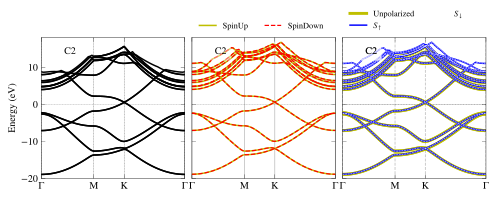

In [ ]:
import matplotlib.pyplot as plt
import pivotpy.parser as vp
import pivotpy.splots as sp

vr1 = vp.export_vasprun(path = f1)
vr2 = vp.export_vasprun(path = f2)

ax0, ax1, ax2 = sp.get_axes(ncols=3,figsize=(8,2.6),sharey=True, sharex=True)

splot_bands(vr1, ax = ax0,color='k',color_='c',lw_ = 0.7,ls_='dashed',elim=[-20,18])
# elim above sets grid automatically, for others, we set later.

splot_bands(vr2,ax=ax1,color='y', ktick_inds=[0,30,60,-1], ktick_vals='ΓMKΓ') #,ktick_vals=['Γ','M','K','Γ'])

splot_bands(vr1, ax=ax2,color='y',label='Unpolarized',lw=3)
splot_bands(vr2, ax=ax2,color='b',color_ = 'w',lw_ = 0.5, ls_ = 'dashed',label=r'$S_\uparrow$',label_ = r'$S_\downarrow$')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.grid(axis='x')
ax2.grid(axis='x',ls='dashed')

plt.subplots_adjust(hspace=0.01,wspace=0.05)

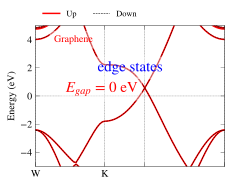

In [ ]:
import pivotpy.splots as sp
ax = splot_bands(path_evr=f2,elim=[-5,5],ktick_inds=[0,30,60,-1],ktick_vals=['W','K','',''],txt='Graphene',ctxt='r',color='r',color_='k',lw_=0.5,label='Up',label_ = 'Down')
add_text(ax=ax,xs=[0.35,0.5],ys=[0.55,0.7],txts=[r'$E_{gap}$ = 0 eV','edge states'],colors=['red','blue'],fontsize=15)

In [ ]:
#export
def add_legend(ax=None,colors=[],labels=[],styles='solid',\
                widths=0.7,anchor=(0,1), ncol=3,loc='lower left',fontsize='small',frameon=False,**kwargs):
    """
    - Adds custom legeneds on a given axes,returns None.
    - **Parameters**
        - ax       : Matplotlib axes.
        - colors   : List of colors.
        - labels   : List of labels.
        - styles   : str or list of line styles.
        - widths   : str or list of line widths.

    kwargs are passed to plt.legend. Given arguments like anchor,ncol etc are preferred.
    """
    kwargs.update(dict(bbox_to_anchor=anchor,ncol=ncol,loc=loc,fontsize=fontsize,frameon=frameon))
    if ax==None:
        raise ValueError("Matplotlib axes (ax) is not given.")
    else:
        if type(widths)==float or type(widths)==int:
            if(type(styles)==str):
                for color,label in zip(colors,labels):
                    ax.plot([],[],color=color,lw=widths,linestyle=styles,label=label)
            else:
                for color,label,style in zip(colors,labels,styles):
                    ax.plot([],[],color=color,lw=widths,linestyle=style,label=label)
        else:
            if(type(styles)==str):
                for color,label,width in zip(colors,labels,widths):
                    ax.plot([],[],color=color,lw=width,linestyle=styles,label=label)
            else:
                for color,label,width,style in zip(colors,labels,widths,styles):
                    ax.plot([],[],color=color,lw=width,linestyle=style,label=label)
        ax.legend(**kwargs)
    return None

In [ ]:
#export
def add_colorbar(ax, cax = None, cmap_or_clist=None,N=256,ticks=None,\
            ticklabels=None,tickloc='right',vertical=True, digits=2,fontsize=8):
    """
    - Plots colorbar on a given axes. This axes should be only for colorbar. Returns None or throws ValueError for given colors.
    - **Parameters**
        - ax         : Matplotlib axes for which colorbar will be added.
        - cax        : Matplotlib axes for colorbar. If not given, one is created.
        - cmap_or_clist: List/array of colors in or colormap's name. If None (default), matplotlib's default colormap is plotted.
        - N          : int, number of color points Default 256.
        - ticks      : List of tick values to show on colorbar. To turn off, give [].
        - ticklabels : List of labels for ticks.
        - tickloc    : Default 'right'. Any of ['right','left','top','bottom'].
        - digits     : Number of digits to show in tick if ticklabels are not given.
        - vertical   : Boolean, default is Fasle.
        - fontsize   : Default 8. Adjustable according to plot space.

    - **Returns**
        - cax : Matplotlib axes for colorbar, you can customize further.
    """
    if cax is None:
        position = 'right' if vertical == True else 'top'
        cax = append_axes(ax,position= position,size='5%',pad=0.05)
    if cmap_or_clist is None:
        colors=np.array([[1,0,1],[1,0,0],[1,1,0],[0,1,0],[0,1,1],[0,0,1],[1,0,1]])
        _hsv_ = LSC.from_list('_hsv_',colors,N=N)
    elif isinstance(cmap_or_clist,(list,np.ndarray)):
        try:
            _hsv_ = LSC.from_list('_hsv_',cmap_or_clist,N=N)
        except Exception as e:
            print(e,"\nFalling back to default color map!")
            _hsv_ = None # fallback
    elif isinstance(cmap_or_clist,str):
        _hsv_ = cmap_or_clist #colormap name
    else:
        _hsv_ = None # default fallback
    
    if ticks != []:
        if ticks is None: # should be before labels
            ticks = np.linspace(1/6,5/6,3, endpoint=True)

        elif isinstance(ticks,(list,tuple, np.ndarray)):
            ticks = np.array(ticks)
            ticks = (ticks - ticks.min())/np.ptp(ticks)

        if ticklabels is None:
            ticklabels = ticks.round(digits).astype(str)
    else:
        ticks = []
        ticklabels = []
           
    c_vals = np.linspace(0,1,N, endpoint = True).reshape((1,N)) # make 2D array

    ticks_param = dict(direction='out',pad= 2,length=2,width=0.3,top=False,left=False,
                        grid_color=(1,1,1,0), grid_alpha=0)
    ticks_param.update({tickloc:True}) # Only show on given side
    cax.tick_params(**ticks_param)
    if vertical == False:
        cax.imshow(c_vals,aspect='auto',cmap=_hsv_,origin='lower', extent=[0,1,0,1])
        cax.set_yticks([])
        cax.xaxis.tick_top() # to show ticks on top by default
        if tickloc == 'bottom':
            cax.xaxis.tick_bottom() # top is by default
        cax.set_xticks(ticks)
        cax.set_xticklabels(ticklabels,rotation=0,ha='center')

    if vertical == True:
        c_vals = c_vals.transpose()
        cax.imshow(c_vals,aspect='auto',cmap=_hsv_,origin='lower',extent=[0,1,0,1])
        cax.set_xticks([])
        cax.yaxis.tick_right() # Show right by default
        if tickloc == 'left':
            cax.yaxis.tick_left() # right is by default
        cax.set_yticks(ticks)
        cax.set_yticklabels(ticklabels,rotation=90,va='center')

    for tick in cax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for child in cax.get_children():
        if isinstance(child, mpl.spines.Spine):
            child.set_color((1,1,1,0.4))
    return cax # Return colorbar axes to perform further customization

Invalid RGBA argument: 4 
Falling back to default color map!


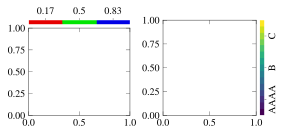

In [ ]:
import pivotpy.splots as sp
import matplotlib.pyplot as plt 
plt.style.use('default')
ax = sp.get_axes(ncols=2,figsize=(4,2))
add_colorbar(ax[0],cmap_or_clist='RGB',vertical=False,N=3)
add_colorbar(ax=ax[1],cmap_or_clist=['r','g','b',4],ticklabels=['AAAA','B',"C"],N=15,tickloc='right')
plt.tight_layout()

In [ ]:
#export
def color_wheel(ax=None,
                xy=(1,1),
                scale = 0.12,
                rlim=(0.2,1),
                N=256,
                colormap=None,
                ticks=[1/6,1/2,5/6],
                labels=['s','p','d'],
                showlegend=True):
    """
    - Returns cax i.e. color wheel axes.
    - **Parameters**
        - ax        : Axes on which color wheel will be drawn. Auto created if not given.
        - xy        : (x,y) of center of wheel.
        - scale     : Scale of the cax internally generated by color wheel.
        - rlim      : Values in [0,1] interval, to make donut like shape.
        - N         : Number of segments in color wheel.
        - colormap  : Matplotlib's color map name. fallbacks to `hsv`.
        - ticks     : Ticks in fractions in interval [0,1].
        - labels    : Ticks labels.
        - showlegend: True or False.
    """
    if ax is None:
        ax = get_axes()
    if colormap is None:
        try: colormap = plt.cm.get_cmap('hsv')
        except: colormap = 'viridis'
    pos = ax.get_position()
    ratio = pos.height/pos.width
    cpos = [pos.x0+pos.width*xy[0]-scale/2,pos.y0+pos.height*xy[1]-scale/2,scale,scale]
    cax = ax.get_figure().add_axes(cpos,projection='polar')
    norm = mpl.colors.Normalize(0.0,2*np.pi)
    t = np.linspace(0,2*np.pi,N)
    r = np.linspace(*rlim,2)
    rg,tg = np.meshgrid(r,t)
    cax.pcolormesh(t,r,tg.T,norm=norm,cmap=colormap,edgecolor='face',shading='gouraud')
    cax.set_yticklabels([])
    cax.spines['polar'].set_visible(False)
    ##########
    if showlegend == True:
        colors = plt.cm.get_cmap(colormap)(ticks) # Get colors values.
        labels = ["◾ "+l for l in labels]
        labels[0] = labels[0]+'\n' #hack to write labels correctly on a single point.
        labels[2] = '\n'+ labels[2]
        for l,p,c in zip(labels,['bottom','center','top'],colors):
            cax.text(rlim[1]+0.1,0.5,l,va=p,ha='left',color=c,transform=cax.transAxes,fontsize=9)
        cax.set_xticklabels([])
    else:
        cax.set_xticks([t*2*np.pi for t in ticks])
        cax.set_xticklabels(labels)
    return cax

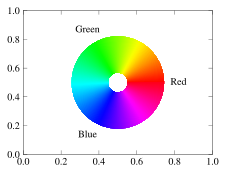

In [ ]:
color_wheel(xy=(0.5,0.5),scale=0.5,colormap='hsv',ticks=[0,1/3,2/3],labels=['Red','Green','Blue'],showlegend=False)

## Including Atomic and Orbital Projections

In [ ]:
#export
def _get_pros_data(
    kpath       = None,
    evals_set   = None,
    pros_set    = None,
    elements    = [[0],],
    orbs        = [[0],],
    interp_nk   = {},
    scale_data  = False,
    ):
    """
    - Returns selected elements/orbitals data.
    - **Parameters**
        - kapath   : `export_vasprun`().kpath or `get_kpts`().kpath.
        - evals_set: `export_vasprun`().bands.evals or `get_evals`().evals. If calculations are spin-polarized, it will be `...evals.SpinUp/SpinDown` for both.
        - pros_set : `export_vasprun().pro_bands.pros` or `get_bands_pro_set`().pros. If calculations are spin-polarized, it will be `...pros.SpinUp/SpinDown` for both.
        - elements : Lists of list of ions to project on, could be `range(start,stop,step)` as well, remember that `stop` is not included in python. so `range(0,2)` will generate 0 and 1 indices.
        - orbs     : List of lists of orbitals indices.
        - scale_data : If True, normalizes projection data to 1.
        - interp_nk   : Dictionary with keys 'n' and 'k' for interpolation.
    - **Returns**
        - A dictionary with keys 'kpath', 'evals', 'colors' that can be unpacked in next function's arguemnet.
            - 'kpath' : Given or interpolated kpath of shape (NKPTS,).
            - 'evals' : Given or interpolated evals_set of shape (NKPTS,NBANDS).
            - 'pros': An array of shape (NKPTS,NBANDS,n) where n is length of input elements list. If scale_data = True, normalizes this array to 1.
    """
    if not np.any(pros_set):
        raise ValueError("Can not process an empty eigenvalues/projection object.\n"
                         "Try with large `elim` in parent function.")
    # Empty orbitals/elements are still allowed on purpose for rgb_lines.
    for elem, orb in zip(elements,orbs):
        if isinstance(elem,int) or isinstance(orb,int):
            raise ValueError("Items in elements and orbs should be list, tuple or range, not int.")

    arrays_list = []
    for elem,orb in zip(elements,orbs):
        pros  = np.take(pros_set,elem,axis=0).sum(axis=0)
        _pros = np.take(pros,orb,axis=2).sum(axis=2)
        arrays_list.append(_pros)
    _shape  = (len(arrays_list),-1,np.shape(_pros)[1])
    _colors = np.concatenate(arrays_list).reshape(_shape).transpose((1,2,0))

    if scale_data: # Normalize overall data
        c_max = np.max(_colors)
        if c_max > 0.0000001: # Avoid division error
            _colors = _colors/c_max

    if interp_nk:
        min_d, max_d = np.min(_colors),np.max(_colors) # For cliping
        from pivotpy import utils as gu
        knew, evals = gu.interpolate_data(kpath,evals_set,**interp_nk)
        _colors     = gu.interpolate_data(kpath,_colors,**interp_nk)[1].clip(min=min_d,max=max_d)
        return {'kpath':knew,'evals': evals,'pros': _colors}
    # Return if no interpolation
    return {'kpath':kpath,'evals': evals_set,'pros': _colors}

def _make_line_collection(max_width   = None,
                         colors_list = None,
                         rgb         = False,
                         **pros_data):
    """
    - Returns a tuple of line collections. If rgb = True (at len(orbs) = 3 in `_get_pros_data`), returns a tuple of two entries, multicolored line collection and RGB maximum values, otherwise return tuple of single colored multiple lines.
    - **Parametrs**
        - **pros_data: Output dictionary from `_get_pros_data` containing kpath, evals and colors arrays.
        - max_width  : Default is None and max linwidth = 2.5. Max inewidth is scaled to max_width if an int of float is given.
        - colors_list: List of colors for multiple lines, length equal to 3rd axis length of colors.
        - rgb        : Default is False. If True and np.shape(colors)[-1] == 3, RGB line collection is returned in a tuple of length 1. Tuple is just to support iteration.
    """
    if not pros_data:
        raise ValueError("No pros_data given.")
    else:
        kpath  = pros_data.get('kpath')
        evals  = pros_data.get('evals')
        pros   = pros_data.get('pros')
    
    for a,t in zip([kpath, evals, pros],['kpath', 'evals', 'pros']):
        if not np.any(a):
            raise ValueError("Missing {!r} from output of `_get_pros_data()`".format(t))

    # Average pros on two consecutive KPOINTS to get that patch color.
    colors = pros[1:,:,:]/2 + pros[:-1,:,:]/2 # Near kpoints avearge
    colors = colors.transpose((1,0,2)).reshape((-1,np.shape(colors)[-1])) # Must before lws

    # Default linewidth = 2.5 unless specified otherwise
    if rgb: # Single channel line widths
        try:
            lws = pros_data.get('lws') #Get from splot_rgb_lines, so lws represent actual data
        except:
            lws = 0.1 + 0.25*np.sum(colors,axis=1) # If not called from splot_rgb_lines
    else: # For separate lines
        lws = 0.1 + 2.5*colors.T # .T to access in for loop.

    if max_width:
        # here division does not fail as min(lws)==0.1
        lws = max_width*lws/(2.5*np.max(lws)) # Only if not None or zero.

    if np.any(colors_list):
        lc_colors = colors_list
    else:
        cmap = plt.cm.get_cmap('viridis')
        lc_colors = cmap(np.linspace(0,1,np.shape(colors)[-1]))
        lc_colors = lc_colors[:,:3] # Skip Alpha

    # Reshaping data same as colors reshaped above, nut making line patches too.
    kgrid = np.repeat(kpath,np.shape(evals)[1],axis=0).reshape((-1,np.shape(evals)[1]))
    narr  = np.concatenate((kgrid,evals),axis=0).reshape((2,-1,np.shape(evals)[1]))
    marr  = np.concatenate((narr[:,:-1,:],narr[:,1:,:]),axis=0).transpose().reshape((-1,2,2))

    # Make Line collection
    if rgb and np.shape(colors)[-1] == 3:
        return (LineCollection(marr,colors=colors,linewidths=lws),)
    else:
        lcs = [LineCollection(marr,colors=_cl,linewidths=lw) for _cl,lw in zip(lc_colors,lws)]
        return tuple(lcs)

- Below are two functions `splot_rgb_lines` and `splot_color_lines`. The difference between the two is that `splot_rgb_lines` works with three `elemenents` only and generates a single variable color and variable thickness line, while `splot_color_lines` plots single colored as many lines as len(elements) with variable thickness.

In [ ]:
#export
def _validate_input(elements,orbs,labels,sys_info,rgb=False):
    "Fix input elements, orbs and labels according to given sys_info. Returns (Bool, elements, orbs,labels)."
    if isinstance(elements,dict): # If elements is a dictionary, it's query_data
        elements, orbs, labels = _format_input(query_data = elements,rgb = rgb)
        
    if len(elements) != len(orbs) or len(elements) != len(labels):
        raise ValueError("`elements`, `orbs` and `labels` expect same length, even if empty.")
    
    elem_inds = sys_info.ElemIndex
    max_ind   = elem_inds[-1]-1 # Last index is used for range in ElemIndex, not python index.
    for i,elem in enumerate(elements.copy()):
        if type(elem) == int:
            try:
                elements[i] = range(elem_inds[elem],elem_inds[elem+1])
                info = f"Given {elem} at position {i+1} of sequence => {sys_info.ElemName[elem]!r}: {elements[i]}. "
                print(gu.color.g(info + f"To just pick one ion, write it as [{elem}]."))
            except:
                raise IndexError(f"Wrap {elem} at position {i+1} of sequence in []. You have only {len(sys_info.ElemName)} types of ions.")

    _es = [e for ee in elements for e in (*ee,)] # important if ee is int
    if  _es and max(_es) > max_ind:
        raise IndexError("index {} is out of bound for {} ions".format(max(_es),max_ind+1))

    # Orbitals Index fixing
    nfields = len(sys_info.fields)
    orbs = [[item] if type(item) == int else item for item in orbs] #Fix if integer given.
    _os = [r for rr in orbs for r in rr]
    if  _os and max(_os) >= nfields:
        raise IndexError("index {} is out of bound for {} orbs".format(max(_os),nfields))

    while rgb and len(elements) < 3: # < 3 as it appends to make it 3.
        elements.append([])
        orbs.append([])
        labels.append('')

    if rgb and len(elements) > 3:
        print('Only keeping first 3 entries in elements/orbs/labels in RGB plots.')
        elements, orbs, labels = elements[:3], orbs[:3], labels[:3]

    # If elements not given, get whole system in case of RGB_Lines
    if rgb and not _es:
        elements = [range(0,max_ind+1),range(0,max_ind+1),range(0,max_ind+1)]
    if rgb and not _os:
        orbs=[[0],[1],[2]] if nfields == 3 else [[0],[1,2,3],[4,5,6,7,8]]
    if rgb and not _es and not _os:
        labels=[sys_info.SYSTEM + v for v in ['-s','-p','-d']]

    return elements,orbs,labels

def _format_input(query_data,rgb=False):
    """
    Format input elements, orbs and labels according to query_data.
    query_data = {'Ga-s':(0,[1]),'Ga-p':(0,[1,2,3]),'Ga-d':(0,[4,5,6,7,8])} #for Ga in GaAs, to pick Ga-1, use [0] instead of 0 at first place
    """
    if not isinstance(query_data,dict):
        raise TypeError("`query_data` must be a dictionary, with keys as labels and values from picked projection indices.")

    # Set default values for different situations
    if rgb:
        elements, orbs, labels = [[],[],[]], [[],[],[]], ['','','']
    else:
        elements, orbs, labels = [[0],], [[0],], ['Element0-s',]

    for i, (k, v) in enumerate(query_data.items()):
        if len(v) != 2:
            raise ValueError(f"{k!r}: {v} expects 2 items (elements, orbs), got {len(v)}.")

        if rgb and i <= 2:
            labels[i] = k
            elements[i], orbs[i] = v[-2:]
        elif rgb and i > 2:
            print("RGB plots can only have 3 items, skipping {}.".format(k))
        elif rgb == False:
            if i == 0:
                labels[0] = k
                elements[0], orbs[0] = v[-2:]
            else:
                labels.append(k)
                elements.append(v[-2])
                orbs.append(v[-1])

    else:
        nt = namedtuple('Selection',['elements','orbs','labels'])
        return nt(elements, orbs, labels)

In [ ]:
#export
from itertools import combinations
from matplotlib import tri
from matplotlib.collections import PolyCollection

def color_cube(ax, colormap = 'brg', loc = (0.67,0.67), size=0.3, 
              N = 7, labels=['s','p','d'],color='k',fontsize=10):
    "Color-mapped hexagon that serves as a legend for `splot_rgb_lines`"
    X, Y = np.mgrid[0:1:N*1j,0:1:N*1j]
    x = X.flatten()
    y = Y.flatten()
    points_z = np.array([x,y,np.ones_like(x)]).T
    points_y = np.array([x,np.ones_like(x),y]).T
    points_x = np.array([np.ones_like(x), x, y]).T
    
    all_points = []
    from pivotpy.sio import to_R3, rotation # Avoids circular import
    ps = to_R3([[1,0,0],[-0.5,-np.sqrt(3)/2,0],[0,0,1]],points_z)
    all_points.extend(ps)
    ps1 = rotation(angle_deg=-120,axis_vec=[0,0,1]).apply(ps+[0,np.sqrt(3),0])
    all_points.extend(ps1)
    ps2 = rotation(angle_deg=180,axis_vec=[0,0,1]).apply(ps*[-1,1,0]+[0,np.sqrt(3),0])
    all_points.extend(ps2)
    
    all_points = rotation(-30,axis_vec=[0,0,1]).apply(all_points)
    
    pts = np.asarray(all_points)[:,:2]
    pts = pts - pts.mean(axis=0) # center
    C = np.array([*points_z, *points_x, *points_y])
    
    fig = ax.get_figure()
    pos = ax.get_position()
    x0 = pos.x0 + loc[0]*pos.width
    y0 = pos.y0 + loc[1]*pos.height
    size = size*pos.width
    cax = fig.add_axes([x0,y0, size, size])
    
    tr1 = tri.Triangulation(*pts.T)
    
    # Have same color for traingles sharing hypotenuse to see box
    colors = []
    for t in tr1.triangles:
        a, b, c = C[t] # a,b,c are the 3 points of the triangle
        long_side = np.linalg.norm(a-b)
        mid_point = (a + b)/2
        for v1,v2 in combinations([a, b, c],2):
            if np.linalg.norm(v1 - v2) > long_side:
                mid_point = (v1 + v2)/2
        
        colors.append(mid_point)
    
    colors = np.array(colors)
    sx,sy,sz = colors.min(axis=0)
    colors[colors[:,0] == 1] -= [0, sy, sz]
    colors[colors[:,1] == 1] -= [sx, 0, sz]
    colors[colors[:,2] == 1] -= [sx, sy, 0]
    
    # Do not dim center of hexagon
    colors[(colors[:,0] > 0.5) & (colors[:,0] <= (1 - 2*sx))] += [2*sx, 0, 0]
    colors[(colors[:,1] > 0.5) & (colors[:,1] <= (1 - 2*sy))] += [0, 2*sy, 0]
    colors[(colors[:,2] > 0.5) & (colors[:,2] <= (1 - 2*sz))] += [0, 0, 2*sz]
        
    A,B,_C = plt.cm.get_cmap(colormap)([0,0.5,1])[:,:3]
    _colors = np.array([(r*A + g*B + b*_C)/((r+g+b) or 1) for r,g,b in colors])
    _max = _colors.max(axis=1,keepdims=True) # Should be normalized after matching to colobar as well
    _max[_max == 0] = 1
    _colors = _colors/_max
    
    col = PolyCollection([pts[t] for t in tr1.triangles],color=_colors,linewidths=0,edgecolor='none',alpha=1)
    cax.add_collection(col)
    cax.autoscale_view()
    cax.set_aspect('equal')
    cax.set_facecolor([1,1,1,0])
    cax.set_axis_off()
    
    
    cax.text(9*np.sqrt(3)/16, -9/16, '→', fontsize=fontsize, zorder = -10, color=color,rotation = -30, ha='center', va='center')
    cax.text(-9*np.sqrt(3)/16, -9/16, '→', fontsize=fontsize, zorder = -10, color=color,rotation = 210, ha='center', va='center')
    cax.text(0, 9/8, '→', fontsize=fontsize, zorder = -10, color=color,rotation = 90, ha='center', va='center')
    
    cax.text(np.sqrt(3)/2,-5/8,f' {labels[0]}' ,color=color,fontsize=fontsize,va='top',ha='center', rotation=-90)
    cax.text(-np.sqrt(3)/2,-5/8,f' {labels[1]}' ,color=color,fontsize=fontsize,va='top',ha='center',rotation=-90)
    cax.text(0, 9/8,f'{labels[2]}  ',color=color,fontsize=fontsize,va='bottom',ha='center',rotation=-90)
    
    return cax

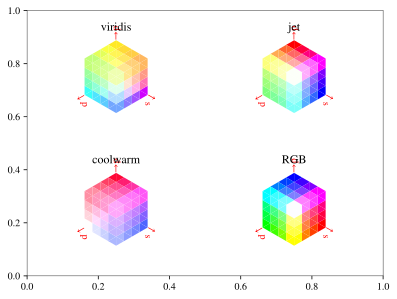

In [ ]:
ax = plt.axes()
for loc, cmap in zip([(0.6,0.1),(0.6,0.6),(0.1,0.6),(0.1,0.1)],['RGB','jet','viridis','coolwarm']):
    cax = color_cube(ax,cmap,loc=loc,size=0.3,color='red',N=5)
    cax.set_title(cmap)

In [ ]:
#export
def splot_rgb_lines(
    path_evr    = None,
    elements    = [[],[],[]],
    orbs        = [[],[],[]],
    labels      = ['','',''],
    ax          = None,
    skipk       = None,
    elim        = [],
    max_width   = None,
    ktick_inds  = [0,-1],
    ktick_vals  = [r'$\Gamma$','M'],
    kseg_inds   = [],
    E_Fermi     = None,
    txt         = None,
    xytxt       = [0.2,0.9],
    ctxt        = 'black',
    spin        = 'both',
    interp_nk   = {},
    scale_data  = True,
    colorbar    = True,
    colormap    = None,
    N           = 11,
    query_data  = {}
    ):
    """
    - Returns axes object and plot on which all matplotlib allowed actions could be performed. In this function,orbs,labels,elements all have list of length 3. Inside list, sublists or strings could be any length but should be there even if empty.
    - **Parameters**
        - path_evr   : path/to/vasprun.xml or output of `export_vasprun`. Auto picks in CWD.
        - elements   : List [[],[],[]] by default and plots s,p,d orbital of system.
        - orbs       : List [[r],[g],[b]] of indices of orbitals, could be empty, but shape should be same.
        - labels     : List [str,str,str] of projection labels. empty string should exist to maintain shape. Auto adds `↑`,`↓` for ISPIN=2. If a label is empty i.e. '', it will not show up in colorbar ticks or legend.
        - ax         : Matplotlib axes object, if not given, one is created.
        - skipk      : Number of kpoints to skip, default will be from IBZKPT.
        - kseg_inds  : Points where kpath is broken.
        - elim       : [min,max] of energy range.
        - E_Fermi    : If not given, automatically picked from `export_vasprun`.
        - ktick_inds : High symmetry kpoints indices.abs
        - ktick_vals : High Symmetry kpoints labels.
        - max_width  : Default is None and linewidth at any point = 2.5*sum(ions+orbitals projection of all three input at that point). Linewidth is scaled to max_width if an int or float is given.
        - txt        : Text on figure, if None, SYSTEM's name is printed.
        - xytxt      : [x_coord,y_coord] of text relative to axes.
        - ctxt       : color of text.
        - spin       : Plot spin-polarized for spin {'up','down','both'}. Default is both.
        - interp_nk  : Dictionary with keys 'n' and 'k' for interpolation.
        - scale_data : Default is True and normalizes projection data to 1. 
        - colorbar   : Default is True. Displays a vertical RGB colorbar. Forfine control, set it False and use `plot_handle.add_colorbar` and `plot_handle.color_cube` just afer plotting. 
        - colormap   : 1.2.7+, Default is None and picks suitable for each case. For all three projections given, only first, middle and last colors are used to interpolate between them.
        - N          : Number of distinct colors in colormap.
        - query_data : Dictionary with keys as label and values as list of length 2. Should be <= 3 for RGB plots. If given, used in place of elements, orbs and labels arguments.
                        Example: {'s':([0,1],[0]),'p':([0,1],[1,2,3]),'d':([0,1],[4,5,6,7,8])} will pick up s,p,d orbitals of first two ions of system.
    - **Returns**
        - ax : matplotlib axes object with plotted projected bands.
        
    > Note: Two figures made by this function could be comapred quantitatively only if `scale_data=False, max_width=None` as these parameters act internally on data.
    """
    # Fix input data
    vr = vp._validate_evr(path_evr=path_evr,skipk=skipk,elim=elim)

    # Fix orbitals, elements and labels lengths very early.
    if query_data:
        elements,orbs,labels = _format_input(query_data,rgb=True) # Preferred over elements,orbs,labels

    elements,orbs,labels = _validate_input(elements,orbs,labels,vr.sys_info,rgb=True)

    # Main working here.
    if vr.pro_bands == None:
        raise ValueError("Can not plot an empty eigenvalues object.\n"
                         "Try with large energy range.")
    if not spin in ('up','down','both'):
        raise ValueError("spin can take any of ['up','down'. 'both'] only.")

    # Small things
    if E_Fermi == None:
        E_Fermi = vr.bands.E_Fermi
    K = vp.join_ksegments(vr.kpath,kseg_inds = kseg_inds)
    xticks = [K[i] for i in ktick_inds]
    xlim = [min(K),max(K)]
    if elim:
        ylim = [min(elim),max(elim)]
    else:
        ylim = []

    # Make axes if not given.
    if not np.any([ax]):
        ax = get_axes()
        
    non_zero_inds = [i for i,e in enumerate(elements) if e]
    #=====================================================
    def _add_collection(gpd_args,mlc_args,ax):
        pros_data = _get_pros_data(**gpd_args)
        _lws_ = 0.1 + 2.5*np.sum(pros_data['pros'],axis=2) # Before changing color, get linewidths
        ax._min_max_c = [(np.min(_lws_) -0.1)/2.5,(np.max(_lws_) - 0.1)/2.5] # Save for later use.
        pros_data['lws']  = np.transpose(_lws_[:-1,:]/2 + _lws_[1:,:]/2).ravel() # NBANDS[NKPTS-1] repeatition.
        # These 'lws' are passed in to _make_line_collection to keep true linwidths even color changes

        colors = pros_data['pros']
        
        if len(non_zero_inds) == 1:
            percent_colors = colors[:,:,non_zero_inds[0]]
            percent_colors = percent_colors/np.max(percent_colors)
            pros_data['pros'] = plt.cm.get_cmap(colormap or 'copper',N)(percent_colors)[:,:,:3] # Get colors in RGB space.
            
        elif len(non_zero_inds) == 2:
            d2_colors = colors[:,:,non_zero_inds]
            _sum = np.sum(d2_colors,axis=2)
            _sum[_sum == 0] = 1
            percent_colors = d2_colors[:,:,1]/_sum # second one is on top
            pros_data['pros'] = plt.cm.get_cmap(colormap or 'coolwarm',N)(percent_colors)[:,:,:3] # Get colors in RGB space.  
        
        else:
            # Normalize color at each point only for 3 projections.
            c_max = np.max(colors,axis=2, keepdims= True)
            c_max[c_max == 0] = 1 #Avoid division error:
            
            colors = colors/c_max # Weights to be used for color interpolation.
            nsegs = np.linspace(0,1,N,endpoint = True)
            for low,high in zip(nsegs[:-1],nsegs[1:]):
                colors[(colors >= low) & (colors < high)] = low
            
            A, B, C = plt.cm.get_cmap(colormap or 'brg',N)([0,0.5,1])[:,:3]
            pros_data['pros'] = np.array([
                [(r*A + g*B + b*C)/((r + g + b) or 1) for r,g,b in _cols] 
                for _cols in colors
            ])
            
            # Normalize after picking colors from colormap as well to match the color_cube.
            c_max = np.max(pros_data['pros'],axis=2, keepdims= True)
            c_max[c_max == 0] = 1 #Avoid division error:
            
            pros_data['pros'] = pros_data['pros']/c_max
            
        line_coll, = _make_line_collection(**pros_data,**mlc_args)
        ax.add_collection(line_coll)
        ax.autoscale_view()
    #====================================================

    # After All Fixing
    ISPIN=vr.sys_info.ISPIN
    # Arguments for _get_pros_data and _make_line_collection
    gpd_args = dict(elements=elements,orbs=orbs,interp_nk=interp_nk,scale_data=scale_data)
    mlc_args = dict(rgb=True,colors_list= None, max_width=max_width)

    if ISPIN == 1:
        gpd_args.update(dict(kpath=K, evals_set=vr.bands.evals-E_Fermi, pros_set=vr.pro_bands.pros))
        _add_collection(gpd_args,mlc_args,ax=ax)
    if ISPIN == 2:
        gpd_args1 = dict(kpath=K,evals_set=vr.bands.evals.SpinUp-E_Fermi,
                        pros_set=vr.pro_bands.pros.SpinUp,**gpd_args)
        gpd_args2 = dict(kpath=K,evals_set=vr.bands.evals.SpinDown-E_Fermi,
                        pros_set=vr.pro_bands.pros.SpinDown,**gpd_args)
        if spin in ['up','both']:
            _add_collection(gpd_args1,mlc_args,ax=ax)
        if spin in ['down','both']:
            _add_collection(gpd_args2,mlc_args,ax=ax)

    # Aethetcis of plot.
    if not txt:
        txt=vr.sys_info.SYSTEM
    add_text(ax=ax,xs=xytxt[0],ys=xytxt[1],txts=txt,colors=ctxt)
    modify_axes(ax = ax, xticks=xticks,xt_labels=ktick_vals,xlim=xlim,ylim=ylim,vlines=True)
    
    _tls_ = [l for l in labels] # To avoid side effects, new labels array.
    for i,label in enumerate(labels):
        if label and ISPIN==2:
            _tls_[i] = (label+'$^↑$' if spin=='up' else label+'$^↓$' if spin=='down' else label+'$^{↑↓}$')
    
    if len(non_zero_inds) ==  1:
        ticks = np.linspace(*ax._min_max_c,5, endpoint=True)
        ticklabels = [f'{t:4.2f}' for t in ticks]
        cmap = colormap or 'copper'
    elif len(non_zero_inds) == 2:
        ticks = [0,1]
        ticklabels = [_tls_[i] for i in non_zero_inds]
        cmap = colormap or 'coolwarm'
    else:
        ticks = None
        ticklabels = _tls_
        cmap = colormap or 'brg'
        
    if colorbar:
        if len(non_zero_inds) < 3:
            cax = add_colorbar(ax=ax,N = N, vertical=True,ticklabels = ticklabels,ticks=ticks,cmap_or_clist = cmap)
            if len(non_zero_inds) ==  1:
                cax.set_title(_tls_[non_zero_inds[0]])
        else:
            color_cube(ax,colormap = colormap or 'brg', labels = _tls_, N = N)
    else:
        # MAKE PARTIAL COLOR CUBE AND COLORBAR HERE FOR LATER USE.
        def recent_colorbar(cax=None,tickloc='right',vertical=True,digits=2,fontsize=8):
            return add_colorbar(ax = ax, cax=cax, cmap_or_clist = cmap, N = N, 
                    ticks = ticks, ticklabels = ticklabels, tickloc = tickloc,
                    vertical=vertical,digits=digits,fontsize=fontsize)
            
        ax.add_colorbar = recent_colorbar
        
        def recent_color_cube(loc = (0.67,0.67), size=0.3 ,color='k',fontsize = 10):
            return color_cube(ax = ax,colormap = cmap, labels = ticklabels, N = N, 
                    loc =loc, size = size, color = color, fontsize = fontsize)
        
        ax.color_cube = recent_color_cube

    return ax

- **splot_rgb_lines()** requires lists for `orbs`,`labels`, and `elements` each of length 3 which will be plotted on one axes. 
    - If you do not provide any arguemnts, this will create graph of s, p,d orbital of the system.
    - `elements` argument is special, you can pass index of element which will pick all ions of that type, or list(length=3) of indices of ions, e.g in `elements=[0,[0,1],2]` of system Ga`32`As`31`Bi`1`, 0 and 2 pick all ions of Ga and Bi respectively, while [0,1] will pick first two ions of Ga.
    - Instead of `elements`, `orbs`, `labels`, you can use `query_data = {'label: [elements list, orbs list],...}`.
    - Use good colormaps that have rich variety of colors like `jet, brg,...`.

c:\users\mass_\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



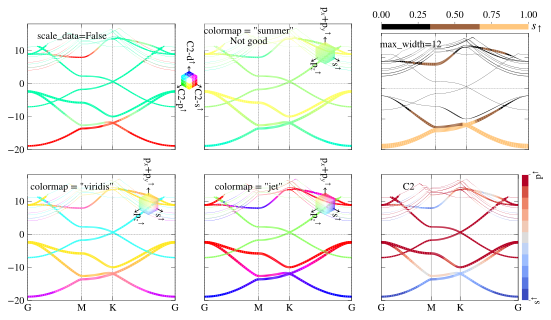

In [ ]:
import os
import numpy as np
import pivotpy as pp
import matplotlib.pyplot as plt
with pp.set_dir('E:/Research/graphene_example/ISPIN_2/bands'):
    vr = pp.Vasprun()
#plt.style.use('ggplot')

args_dict = dict(path_evr=vr.data,xytxt=(0.3,0.9),elim=[-20,18])

axs=get_axes(nrows=2,ncols=3,figsize=(9,5),sharex=True,sharey=True)
ax = splot_rgb_lines(ax=axs[0,0],**args_dict,N =4, scale_data=False,spin='up',txt='scale_data=False',colorbar=False,colormap='RGB')
ccax = ax.color_cube(loc=(0.55,0.6),size=0.5) 
pos = ccax.get_position() # Relocate color-cube
ccax.set_position([pos.x0*1.29,pos.y0*0.9,pos.width*0.5,pos.height])

args_dict['query_data'] = {'s':[range(2),[0]],'p$_z$':[range(2),[2]],'p$_x$+p$_y$':[range(2),[1,3]]}
splot_rgb_lines(ax=axs[0,1],**args_dict,spin='up',txt='colormap = "summer"\nNot good',colormap = 'summer')

#plt.style.use(['default','seaborn'])
_ = splot_rgb_lines(ax=axs[1,0],**args_dict,spin='up',txt='colormap = "viridis"',colormap = 'viridis')
_ = splot_rgb_lines(ax=axs[1,1],**args_dict,N = 20, spin='up',txt='colormap = "jet"',colormap = 'jet')

ax_s = splot_rgb_lines(vr.data, ax=axs[0,2],spin='up',N = 3,query_data={'s':[[0],[0]]},max_width=12,txt='max_width=12',elim=[-20,18],colorbar=False)
cax = ax_s.add_colorbar(vertical=False)
cax.text(1,0.5,r' $s_ \uparrow$',ha='left',va='center',fontsize=12)
last_ax = splot_rgb_lines(vr.data, ax=axs[1,2],spin='up',query_data={'s':[[0],[0]],'p':[[0],[1,2,3]]},ktick_inds=[0,30,60,-1],ktick_vals='GMKG')
last_ax.grid(axis='x')

In [ ]:
#export
def splot_color_lines(
    path_evr      = None,
    elements      = [[0]],
    orbs          = [[0]],
    labels        = ['s'],
    axes          = None,
    skipk         = None,
    kseg_inds     = [],
    elim          = [],
    colormap      = 'gist_rainbow',
    scale_data    = False,
    max_width     = None,
    spin          = 'both',
    ktick_inds    = [0, -1],
    ktick_vals     = ['$\\Gamma$', 'M'],
    E_Fermi       = None,
    showlegend    = True,
    xytxt         = [0.2, 0.85],
    ctxt          = 'black',
    interp_nk     = {},
    legend_kwargs = {'ncol': 4, 'anchor': (0, 1.05),
                   'handletextpad': 0.5, 'handlelength': 1,
                   'fontsize': 'small', 'frameon': False},
    query_data    = {},
     **subplots_adjust_kwargs):
    """
    - Returns axes object and plot on which all matplotlib allowed actions could be performed. If given, elements, orbs, and labels must have same length. If not given, zeroth ion is plotted with s-orbital.
    - **Parameters**
        - path_evr   : Path/to/vasprun.xml or output of `export_vasprun`. Auto picks in CWD.
        - elements   : List [[0],], by defualt and plot first ion's projections.
        - orbs       : List [[0],] lists of indices of orbitals, could be empty.
        - labels     : List [str,] of orbitals labels. len(labels)==len(orbs) must hold.  Auto adds `↑`,`↓` for ISPIN=2. If a label is empty i.e. '', it will not show up in legend.
        - axes       : Matplotlib axes object with one or many axes, if not given, auto created.
        - skipk      : Number of kpoints to skip, default will be from IBZKPT.
        - kseg_inds : Points where kpath is broken.
        - elim       : [min,max] of energy range.
        - E_Fermi    : If not given, automatically picked from `export_vasprun`.
        - ktick_inds : High symmetry kpoints indices.abs
        - ktick_vals  : High Symmetry kpoints labels.
        - colormap  : Matplotlib's standard color maps. Default is 'gist_ranibow'.
        - showlegend : True by defualt and displays legend relative to axes[0]. If False, it writes text on individual ax.
        - scale_data : Default is False, If True, normalize projection data to 1.
        - max_width  : Width to scale whole projections. Default is None and linewidth at any point on a line = 2.5*sum(ions+orbitals projection of the input for that line at that point). Linewidth is scaled to max_width if an int or float is given.
        - xytxt      : [x_coord,y_coord] of labels relative to axes. Works if showlegend = False.
        - ctxt       : color of text of labels
        - spin       : Plot spin-polarized for spin {'up','down','both'}. Default is both.
        - interp_nk   : Dictionary with keys 'n' and 'k' for interpolation.
        - legend_kwargs: Dictionary containing legend arguments.
        - query_data : Dictionary with keys as label and values as list of length 2. If given, used in place of elements, orbs and labels arguments.
                        Example: {'s':([0,1],[0]),'p':([0,1],[1,2,3]),'d':([0,1],[4,5,6,7,8])} will pick up s,p,d orbitals of first two ions of system.
        - **subplots_adjust_kwargs : plt.subplots_adjust parameters.
    - **Returns**
        - axes : matplotlib axes object [one or list of axes] with plotted projected bands.
    > Note: Two figures made by this function could be comapred quantitatively only if `scale_data=False, max_width=None` as these parameters act internally on data.
    """
    # Fix data input
    vr = vp._validate_evr(path_evr=path_evr,skipk=skipk,elim=elim)
    # Fix orbitals, elements and labels lengths very early.
    if query_data:
        elements, orbs, labels = _format_input(query_data=query_data,rgb=False)# preferred over elements, orbs, labels

    elements,orbs,labels = _validate_input(elements,orbs,labels,vr.sys_info)

    # Main working here.
    if vr.pro_bands == None:
        raise ValueError("Can not plot an empty eigenvalues object.\n"
                         "Try with large energy range.")
    if not spin in ('up','down','both'):
        raise ValueError("spin can take any of ['up','down'. 'both'] only.")


    # Small things
    if E_Fermi == None:
        E_Fermi = vr.bands.E_Fermi
    K = vp.join_ksegments(vr.kpath,kseg_inds=kseg_inds)
    xticks = [K[i] for i in ktick_inds]
    xlim = [min(K),max(K)]
    if elim:
        ylim = [min(elim),max(elim)]
    else:
        ylim = []

    # Fix elements and colors length. ISPIN 2 case is done in loop itself
    if colormap not in plt.colormaps():
        c_map = plt.cm.get_cmap('viridis')
        print("colormap = {!r} not exists, falling back to default color map.".format(colormap))
    else:
        c_map = plt.cm.get_cmap(colormap)
    c_vals = np.linspace(0,1,len(orbs))
    colors  = c_map(c_vals)

    # After All Fixing
    ISPIN=vr.sys_info.ISPIN
    # Arguments for _get_pros_data and _make_line_collection
    gpd_args = dict(elements=elements,orbs=orbs,interp_nk=interp_nk,scale_data=scale_data)
    mlc_args = dict(rgb=False,colors_list= colors, max_width=max_width)
    
    #============================================================
    def _plot_collection(gpd_args,mlc_args,axes=None):
        if not np.any([axes]):
            axes = get_axes()
        axes = np.array([axes]).ravel() # Safe list any axes size
        pros_data  = _get_pros_data(**gpd_args)
        line_coll  = _make_line_collection(**pros_data,**mlc_args)
        if len(axes) != len(line_coll):
            axes = [axes[0] for l_c in line_coll]
        _ = [ax.add_collection(lc) for ax, lc in zip(axes,line_coll)]
        _ = [ax.autoscale_view() for ax in axes]
        return axes
    #============================================================

    if(ISPIN==1):
        gpd_args.update(dict(kpath=K,evals_set=vr.bands.evals-E_Fermi,pros_set=vr.pro_bands.pros))
        axes = _plot_collection(gpd_args,mlc_args,axes=axes)
    if ISPIN == 2:
        gpd_args1 = dict(kpath=K,evals_set=vr.bands.evals.SpinUp-E_Fermi,
                        pros_set=vr.pro_bands.pros.SpinUp,**gpd_args)
        gpd_args2 = dict(kpath=K,evals_set=vr.bands.evals.SpinDown-E_Fermi,
                        pros_set=vr.pro_bands.pros.SpinDown,**gpd_args)
        if spin in ['up','both']:
            axes = _plot_collection(gpd_args1,mlc_args,axes=axes)
        if spin in ['down','both']:
            axes = _plot_collection(gpd_args2,mlc_args,axes=axes)

    # Aesthetics
    _tls_ = [l for l in labels] # To avoid side effects, new labels array.
    for i,label in enumerate(labels):
        if label and ISPIN==2:
            _tls_[i] = (label+'$^↑$' if spin=='up' else label+'$^↓$' if spin=='down' else label+'$^{↑↓}$')

    if showlegend:
        width = (max_width/2 if max_width else 2.5)
        add_legend(ax=axes[0],colors=colors,labels=_tls_,widths=width,**legend_kwargs)
    else:
        x,y=[*xytxt]
        _ = [add_text(ax=ax,xs=x,ys=y,txts=_tl_,colors=ctxt) for ax,_tl_ in zip(axes,_tls_)]
    _ = [modify_axes(ax=ax,xticks=xticks,xt_labels=ktick_vals,xlim=xlim,ylim=ylim,vlines=True) for ax in axes]
    plt.subplots_adjust(**subplots_adjust_kwargs)
    return axes

- **splot_color_lines()** requires equal length lists for `orbs`,`labels`, and `elements` either with one axis or mutltiple axes of same length as `orbs`. 
    - If you do not provide any arguemnts, this will plots-orbital of first ion. 
    - `elements` argument is special, you can pass index of element which will pick all ions of that type, or list of indices of ions, e.g in `elements=[0,[0,1],2]` of system Ga`32`As`31`Bi`1`, 0 and 2 pick all ions of Ga and Bi respectively, while [0,1] will pick first two ions of Ga.
    - Instead of `elements`, `orbs`, `labels`, you can use `query_data = {'label: [elements list, orbs list],...}`.
    - If your given `len(axis)=1`, all projections are plotted on single axis and you can tweak plot aesthetics, legend display etc. There are plenty of options.
    - If a label is empty i.e. '', it will not show up in legend. 

## Colors Selection
Instead of giving custom colors, you can use matplotlib's colormaps to be consistent. Use 
```python
plt.colormaps()
```
to see list of available color maps. To get a color array from a map, you can do the following:
```python
from matplotlib.pyplot import cm
colors  = cm.hsv(np.linspace(0,1,3))
# This will give you three colors from 'hsv' map.
```
You can create your own colormap by a list of colors 
```python
import pivotpy as pp 
cm = pp.create_colormap('RB',['r','b])
cm(0.5) #will give you magenta color between red and blue
```
> **Note**: A custom colormaps `RGB` is registered in session when you import pivotpy, which could be used when plotting DOS with bands of same color.

In [ ]:
import os
path='E:/Research/graphene_example/ISPIN_2/bands'
os.chdir(path)
import pivotpy 
import importlib as imp
pp = imp.reload(pivotpy)
import matplotlib.pyplot as plt
axs = pp.get_axes(nrows=2,ncols=3,figsize=(7,5),sharey=True,sharex=True)
args_dict=dict(elements=[0,0,[0,1]],orbs=[0,1,[2]],labels=['s','$p_z$','$p_x$'],
               hspace=0.1,wspace=0.07,showlegend=True,elim=[-20,18],
               ktick_inds=[0,30,60,-1], ktick_vals=['$\Gamma$','M','K','$\Gamma$'],)

splot_color_lines(axes=axs[0,0],**args_dict,left=0.06,colormap='flag',spin='up');
splot_color_lines(axes=axs[0,1],**args_dict,left=0.06,colormap='Something',spin='down',scale_data=True);
splot_color_lines(axes=axs[0,2],**args_dict,left=0.06,colormap='RGB',spin='both',query_data={'p':[[0,1],[1,2,3]]})

args_dict['showlegend'] = False
splot_color_lines(axes=axs[1,:],**args_dict,left=0.06,colormap='flag',spin='up',xytxt=(0.1,0.9));
axs[0,2].add_text(0.5,1,'query_data takes preference \nover elements, orbs and labels')

 Given 0 at position 1 of sequence => 'C': range(0, 2). To just pick one ion, write it as [0].
 Given 0 at position 2 of sequence => 'C': range(0, 2). To just pick one ion, write it as [0].
colormap = 'Something' not exists, falling back to default color map.


## Plotting Density of States

In [ ]:
#export
def _select_pdos(
    tdos        = None,
    pdos_set    = None,
    ions        = [0,],
    orbs        = [0,],
    E_Fermi     = 0,
    interp_nk   = {}
     ):
    """
    - Returns (interpolated/orginal) enrgy(N,), tdos(N,), and pdos(N,) of selected ions/orbitals.
    - **Parameters**
        - tdos     : `export_vasprun`().tdos or `get_tdos`().tdos. If calculations are spin-polarized, it will be `..tdos.SpinUp/SpinDown` for both. You need to apply this function twice for SpinUp and SpinDown separately.
        - pdos_set : `export_vasprun().pro_dos.pros` or `get_dos_pro_set`().pros. If calculations are spin-polarized, it will be `...pros.SpinUp/SpinDown` for both.
        - ions     : List of ions to project on, could be `range(start,stop,step)` as well, remember that `stop` is not included in python. so `range(0,2)` will generate 0 and 1 indices.
        - orbs     : List of orbitals indices to pick.
        - E_Fermi  : Here it is zero. Needs to be input.
        - interp_nk   : Dictionary with keys 'n' and 'k' for interpolation.
    """
    if tdos==[]:
        raise ValueError("Can not plot empty DOS.")
    en = tdos[:,0]-E_Fermi
    t_dos = tdos[:,1]
    pros = np.take(pdos_set[:,:,1:],list(ions),axis=0).sum(axis=0)
    p_dos = np.take(pros,orbs,axis=1).sum(axis=1)
    if interp_nk:
        from pivotpy import utils as gu
        _en,_tdos=gu.interpolate_data(en,t_dos,**interp_nk)
        _tdos = _tdos.clip(min=0)
        _pdos = gu.interpolate_data(en,p_dos,**interp_nk)[1].clip(min=0)
    else:
        _en,_tdos,_pdos=pdos_set[0,:,0]-E_Fermi,t_dos,p_dos # reading _en from projected dos if not interpolated.

    return _en,_tdos,_pdos

In [ ]:
#export
def _collect_dos(
    path_evr      = None,
    elim          = [],
    elements      = [[0],],
    orbs          = [[0],],
    labels        = ['s',],
    E_Fermi       = None,
    spin          = 'both',
    interp_nk     = {}
    ):
    """
    - Returns lists of energy,tdos, pdos and labels. If given,elements,orbs and labels must have same length. If not given, zeroth ions is collected with s-orbital.
    - **Parameters**)
        - path_evr   : Path/to/vasprun.xml or output of `export_vasprun`. Auto picks in CWD.
        - elim       : [min,max] of energy range.
        - E_Fermi    : If not given, automatically picked from `export_vasprun`.
        - elements   : List [[0],], by defualt and plot first ion's projections.
        - orbs       : List [[0],] lists of indices of orbitals, could be empty.
        - labels     : List [str,] of orbitals labels. len(labels)==len(orbs) must hold.  Auto adds `↑`,`↓` for ISPIN=2.
        - spin       : Plot spin-polarized for spin {'up','down','both'}. Default is both.
        - interp_nk   : Dictionary with keys 'n' and 'k' for interpolation.
    - **Returns**
        - Energy : (N,1) size.
        - tdos   : (N,1) size or [(N,1),(N,1)] if spin polarized.
        - pdos   : [(N,1),(N,1),...], spin polarized is auto-fixed.
        - labels : ['label1,'label2',...] spin polarized is auto-fixed.
        - vr     : Exported vasprun.
    """
    vr = vp._validate_evr(path_evr=path_evr,elim=elim)

    # Fix orbitals, elements and labels lengths very early.
    elements,orbs,labels = _validate_input(elements,orbs,labels,vr.sys_info)

    # Main working here.
    if vr.pro_dos == None:
        raise ValueError("Can not plot an empty DOS object.")
    if not spin in ('up','down','both'):
        raise ValueError(
            "spin can take `up`,`down` or `both` values only.")
        return

    if(E_Fermi==None):
        E_Fermi=vr.tdos.E_Fermi
    nfields = len(vr.pro_dos.labels) - 1 #


    # After All Fixing
    ISPIN=vr.sys_info.ISPIN
    e,ts,ps,ls=None,None,[],[] # to collect all total/projected dos.
    for elem,orb,label in zip(elements,orbs,labels):
        args_dict=dict(ions=elem,orbs=orb,interp_nk=interp_nk,E_Fermi=E_Fermi)
        if ISPIN==1:
            tdos=vr.tdos.tdos
            pdos_set=vr.pro_dos.pros
            e,t,p = _select_pdos(tdos=tdos,pdos_set=pdos_set, **args_dict)
            ps.append(p)
            ls.append(label)
            ts = t
        if ISPIN==2:
            tdos1=vr.tdos.tdos.SpinUp
            tdos2=vr.tdos.tdos.SpinDown
            pdos_set1=vr.pro_dos.pros.SpinUp
            pdos_set2=vr.pro_dos.pros.SpinDown
            if spin=='up':
                e,t1,p1 = _select_pdos(tdos=tdos1,pdos_set=pdos_set1, **args_dict)
                ps.append(p1)
                ls.append((label+'$^↑$' if label else ''))
                ts = t1
            if spin=='down':
                e,t2,p2 = _select_pdos(tdos=tdos2,pdos_set=pdos_set2, **args_dict)
                ps.append(p2)
                ls.append((label+'$^↓$' if label else ''))
                ts = t2
            if spin=='both':
                e,t1,p1 = _select_pdos(tdos=tdos1,pdos_set=pdos_set1, **args_dict)
                ps.append(p1)
                ls.append((label+'$^↑$' if label else ''))
                e,t2,p2 = _select_pdos(tdos=tdos2,pdos_set=pdos_set2, **args_dict)
                ps.append(-p2)
                ls.append((label+'$^↓$' if label else ''))
                ts=[t1,-t2]
    return e,ts,ps,ls,vr

- Providing labels while using `_collect_dos` is important, it will automatically return spin up/down saymbols.

In [ ]:
#export 
def splot_dos_lines(
    path_evr      = None,
    elements      = [[0],],
    orbs          = [[0],],
    labels        = ['s',],
    ax            = None,
    elim          = [],
    include_dos   = 'both',
    colormap      = 'gist_rainbow',
    tdos_color    = (0.8,0.95,0.8),
    linewidth     = 0.5,
    fill_area     = True,
    vertical      = False,
    E_Fermi       = None,
    spin          = 'both',
    interp_nk     = {},
    showlegend    = True,
    legend_kwargs = {'ncol'         : 4,
                   'anchor'         : (0,1),
                   'handletextpad'  : 0.5,
                   'handlelength'   : 1,
                   'fontsize'       : 'small',
                   'frameon'        : False
                   },
    query_data    = {}
    ):
        """
        - Returns ax object (if ax!=False) and plot on which all matplotlib allowed actions could be performed, returns lists of energy,tdos and pdos and labels. If given,elements,orbs colors, and labels must have same length. If not given, zeroth ions is plotted with s-orbital.
        - **Parameters**)
            - path_evr   : Path/to/vasprun.xml or output of `export_vasprun`. Auto picks in CWD.
            - elements   : List [[0],], by defualt and plot first ion's projections.
            - orbs       : List [[0],] lists of indices of orbitals, could be empty.
            - labels     : List [str,] of orbitals labels. len(labels)==len(orbs) must hold.  Auto adds `↑`,`↓` for ISPIN=2.
            - ax         : Matplotlib axes object, if None, one is created. If False, data lists are returned.
            - include_dos: One of {'both','tdos','pdos'}.
            - elim       : [min,max] of energy range.
            - E_Fermi    : If not given, automatically picked from `export_vasprun`.
            - colormap   : Matplotlib's standard color maps. Default is 'gist_ranibow'.
            - fill_area  : Default is True and plots filled area for dos. If False, plots lines only.
            - vertical   : False, If True, plots along y-axis.
            - showlegend : True by defualt.
            - spin       : Plot spin-polarized for spin {'up','down','both'}. Default is both.
            - interp_nk   : Dictionary with keys 'n' and 'k' for interpolation.
            - legend_kwargs: Dictionary to contain legend arguments to fix.
            - query_data : Dictionary with keys as label and values as list of length 2. If given, used in place of elements, orbs and labels arguments.
                        Example: {'s':([0,1],[0]),'p':([0,1],[1,2,3]),'d':([0,1],[4,5,6,7,8])} will pick up s,p,d orbitals of first two ions of system.
        - **Returns**
            - ax         : Matplotlib axes.
        """
        if include_dos not in ('both','pdos','tdos'):
            raise ValueError("`include_dos` expects one of ['both','pdos','tdos'], got {}.".format(include_dos))

        if query_data:
            elements,orbs,labels=_format_input(query_data,rgb=False) # prefer query_data over elements,orbs,labels

        en,tdos,pdos,vr=None,None,None,None # Placeholders for defining. must be here.
        cl_dos=_collect_dos(path_evr=path_evr,
                            elim=elim,
                            elements=elements,
                            orbs=orbs,
                            labels=labels,
                            E_Fermi=E_Fermi,
                            spin=spin,
                            interp_nk=interp_nk)
        try:
            en,tdos,pdos,labels,vr=cl_dos # Labels updated
        except:
            raise ValueError("Try with large energy range.")
        
        if len(tdos) == 2:
            c_map   = plt.cm.get_cmap(colormap)
            c_vals  = np.linspace(0,1,2*len(orbs))
            colors  = c_map(c_vals)
        else:
            c_map   = plt.cm.get_cmap(colormap)
            c_vals  = np.linspace(0,1,len(orbs))
            colors  = c_map(c_vals)
        
        # Make additional colors for spin down. Inverted colors are better.
        t_color=mpl.colors.to_rgb(tdos_color)
        it_color=gu.transform_color(t_color,c=-1) # -1 contrast inverts color
        if ax == None:
            ax = get_axes()
        if vertical == False:
            if fill_area == False:
                if include_dos != 'pdos':
                    if len(tdos) == 2:   # Spin polarized.
                        ax.plot(en,tdos[0],color=(t_color),label=r'TDOS$^↑$',lw=linewidth)
                        ax.plot(en,tdos[1],color=(it_color),label=r'TDOS$^↓$',lw=linewidth)
                    else:   # unpolarized.
                        ax.plot(en,tdos,color=(t_color),label='TDOS',lw=linewidth)
                if include_dos != 'tdos':
                    for p,l,c in zip(pdos,labels,colors):
                        ax.plot(en,p, color=(c),linewidth=linewidth,label=l)
            if fill_area == True:
                if include_dos != 'pdos':
                    if len(tdos) == 2:   # Spin polarized.
                        ax.fill_between(en,tdos[0],color=(t_color),label=r'TDOS$^↑$',lw=0)
                        ax.fill_between(en,tdos[1],color=(it_color),label=r'TDOS$^↓$',lw=0)
                    else:   # unpolarized.
                        ax.fill_between(en,tdos,color=(t_color),label='TDOS',lw=0)
                if include_dos != 'tdos':
                    for p,l,c in zip(pdos,labels,colors):
                        ax.fill_between(en,p,color=(mpl.colors.to_rgba(c,0.4)),linewidth=0)
                        ax.plot(en,p, color=(c),linewidth=linewidth,label=l)
            if elim:
                ax.set_xlim([min(elim),max(elim)])
        if vertical == True:
            if fill_area == False:
                if include_dos != 'pdos':
                    if len(tdos) == 2:   # Spin polarized.
                        ax.plot(tdos[0],en,color=(t_color),label=r'TDOS$^↑$',lw=linewidth)
                        ax.plot(tdos[1],en,color=(it_color),label=r'TDOS$^↓$',lw=linewidth)
                    else:   # unpolarized.
                        ax.plot(tdos,en,color=(t_color),label='TDOS',lw=linewidth)
                if include_dos != 'tdos':
                    for p,l,c in zip(pdos,labels,colors):
                        ax.plot(p,en, color=(c),linewidth=linewidth,label=l)
            if fill_area == True:
                if include_dos != 'pdos':
                    if len(tdos) == 2:   # Spin polarized.
                        ax.fill_betweenx(en,tdos[0],color=(t_color),label=r'TDOS$^↑$',lw=0)
                        ax.fill_betweenx(en,tdos[1],color=(it_color),label=r'TDOS$^↓$',lw=0)
                    else:   # unpolarized.
                        ax.fill_betweenx(en,tdos,color=(t_color),label='TDOS',lw=0)
                if include_dos != 'tdos':
                    for p,l,c in zip(pdos,labels,colors):
                        ax.fill_betweenx(en,p,color=(mpl.colors.to_rgba(c,0.4)),linewidth=0)
                        ax.plot(p,en, color=(c),linewidth=linewidth,label=l)
            if elim:
                ax.set_ylim([min(elim),max(elim)])
        if showlegend == True:
            add_legend(ax=ax,labels=[],colors=colors,widths=linewidth,**legend_kwargs)
        return ax

 Given 0 at position 2 of sequence => 'C': range(0, 2). To just pick one ion, write it as [0].


c:\users\mass_\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



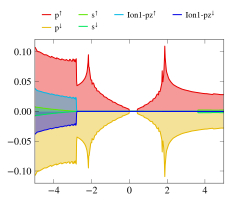

In [ ]:
ax = splot_dos_lines(path_evr='E:/Research/graphene_example/ISPIN_2/dos/vasprun.xml',
                vertical=False,fill_area=True,showlegend=True,include_dos='pdos',linewidth=1,
                orbs=[[1,2,3],0,1],elements=[[0],0,[1]],labels=['p','s','Ion1-pz'],
                colormap='RGB',elim=[-5,5],spin='both')


### High Display Image in Notebook
The function below `plt2html` is implemented for use in `pivotpy-dash` app to view and save SVG image directly from web app's interface. This also enables high display output in jupyter notebook. 

In [ ]:
#export
def plt2html(plt_fig=None,transparent=True,dash_html=None):
    """
    - Returns base64 encoded Image to display in notebook or HTML <svg> or plotly's dash_html_components.Img object.
    - **Parameters**
        - plt_fig    : Matplotlib's figure instance, auto picks as well.
        - transparent: True of False for fig background.
        - dash_html  : Default is None which results in an image display in jupyter notebook.
            - If True, returns html.Img object for plotly's dash.
            - If False, returns <svg> object to embed in HTML DOM.
    """
    if plt_fig==None:
        plt_fig = plt.gcf()
    plot_bytes = BytesIO()
    plt.savefig(plot_bytes,format='svg',transparent=transparent)
    if dash_html == None:
        try:
            shell = get_ipython().__class__.__name__
            if shell == 'ZMQInteractiveShell' or shell=='Shell': #Shell for Colab. Don't know why Google ...
                _ = plt.clf() # Clear other display
                return HTML('<svg' + plot_bytes.getvalue().decode('utf-8').split('<svg')[1])
        except:
            return plt.show()
    elif dash_html==False:
        _ = plt.clf() # Clear image
        return '<svg' + plot_bytes.getvalue().decode('utf-8').split('<svg')[1]
    else:
        import base64
        _ = plt.clf() # Clear image
        import dash_html_components as html
        img = base64.b64encode(plot_bytes.getvalue())
        return html.Img(src="data:image/svg+xml;base64,{}".format(img.decode('utf-8')))

In [ ]:
import pivotpy as pp 
import matplotlib.pyplot as plt
pp.Vasprun("E:/Research/graphene_example/ISPIN_1/bands/vasprun.xml",elim=[-9,9]).splot_bands()
fig = plt2html(dash_html=None,transparent=False)
fig

<Figure size 489.6x374.4 with 0 Axes>

Below code snippest could be used to inclue svg in html document from a figure.
```python
data = plt2html(dash_html=False)
html_str= """
<!DOCTYPE html>
<head></head>
<body>
    <div>
    {}
    </div>
</body>
""".format(data)

with open('fig.html','w') as f:
    f.write(html_str)
```

In [ ]:
#export
from plotly.io._base_renderers import open_html_in_browser
def show(transparent=False):
    """Displays all available figures in browser without blocking terminal"""
    for i in plt.get_fignums():
        svg = plt2html(plt.figure(i),transparent = transparent,dash_html=False)
        html_str= """\
<!DOCTYPE html>
<head></head>
<body>
    <div>
    {}
    </div>
</body>
""".format(svg)
        open_html_in_browser(html_str)
        del svg, html_str

def savefig(filename, dpi=600,**kwargs):
    """Save matplotlib's figure while handling existing files. `kwargs` are passed to `plt.savefig`"""
    #Avoids File Overwrite
    plt.savefig(gu.prevent_overwrite(filename),dpi=dpi,**kwargs)

In [ ]:
#export
def plt2text(plt_fig=None,width=144,vscale=0.96,colorful=True,invert=False,crop=False,outfile=None):
    """Displays matplotlib figure in terminal as text. You should use a monospcae font like `Cascadia Code PL` to display image correctly. Use before plt.show().
    - **Parameters**
        - plt_fig: Matplotlib's figure instance. Auto picks if not given.
        - width  : Character width in terminal, default is 144. Decrease font size when width increased.
        - vscale : Useful to tweek aspect ratio. Default is 0.96 and prints actual aspect in `Cascadia Code PL`. It is approximately `2*width/height` when you select a single space in terminal.
        - colorful: Default is False, prints colored picture if terminal supports it, e.g Windows Terminal.
        - invert  : Defult is False, could be useful for grayscale image.
        - crop    : Default is False. Crops extra background, can change image color if top left pixel is not in background, in that case set this to False.
        - outfile: If None, prints to screen. Writes on a file.
    """
    if plt_fig==None:
        plt_fig = plt.gcf()
    plot_bytes = BytesIO()
    plt.savefig(plot_bytes,format='png',dpi=600)
    img = PIL.Image.open(plot_bytes)
    # crop
    if crop:
        bg   = PIL.Image.new(img.mode, img.size, img.getpixel((0,0)))
        diff = PIL.ImageChops.difference(img, bg)
        diff = PIL.ImageChops.add(diff, diff, 2.0, -100) # No idea how it works
        bbox = diff.getbbox()
        img  = img.crop(bbox)

    w, h   = img.size
    aspect = h/w
    height = np.ceil(aspect * width * vscale).astype(int) # Integer
    height = height if height % 2 == 0 else height + 1 #Make even. important

    if colorful:
        img  = img.resize((width, height)).convert('RGB')
        data = np.reshape(img.getdata(),(height,width,-1))[...,:3]
        data = 225 - data if invert else data #Inversion
        fd   = data[:-1:2,...] #Foreground
        bd   = data[1::2,...]  # Background
        # Upper half block is forground and lower part is background, so one spot make two pixels.
        d_str  = "\033[48;2;{};{};{}m\033[38;2;{};{};{}m\u2580\033[00m" #Upper half block
        pixels = [[d_str.format(*v1,*v2) for v1,v2 in zip(b,f)] for b,f in zip(bd,fd)]

    else:
        height = int(height/2) #
        chars  = ['.',':',';','+','*','?','%','S','#','@']
        chars  = chars[::-1] if invert else chars #Inversion
        img    = img.resize((width, height)).convert('L') # grayscale
        pixels = [chars[int(v*len(chars)/255) -1] for v in img.getdata()]
        pixels = np.reshape(pixels,(height,-1)) #Make row/columns

    out_str = '\n'.join([''.join([p for p in ps]) for ps in pixels])

    if outfile:
        with open(outfile,'w') as f:
            f.write(out_str)
    else:
        # For loop is important for printing lines, otherwise breaks appear.
        for line in out_str.splitlines():
            print(line)

## LOCPOT/CHG Plot

In [ ]:
#export
def plot_potential(basis = None,
           e_or_m=None,
           operation='mean_z',
           ax=None,
           period=None,
           lr_pos=(0.25,0.75),
           lr_widths = [0.5,0.5],
           labels=(r'$V(z)$',r'$\langle V \rangle _{roll}(z)$',r'$\langle V \rangle $'),
           colors = ((0,0.2,0.7),'b','r'),
           annotate = True
          ):
    """
    - Returns tuple(ax,Data) where Data contains resultatnt parameters of averaged potential of LOCPOT.
    - **Parameters**
        - e_or_m : `epxort_potential().[e,m,m_x,m_y,m_z]` is 3D grid data. As `epxort_potential` is slow, so compute it once and then plot the output data.
        - operation: Default is 'mean_z'. What to do with provided volumetric potential data. Anyone of these 'mean_x','min_x','max_x','mean_y','min_y','max_y','mean_z','min_z','max_z'.
        - ax: Matplotlib axes, if not given auto picks.
        - period: Periodicity of potential in fraction between 0 and 1. For example if a slab is made of 4 super cells in z-direction, period=0.25.
        - lr_pos: Locations around which averages are taken.Default (0.25,0.75). Provide in fraction between 0 and 1. Center of period is located at these given fractions. Work only if period is given.
        - lr_widths: Default is [0.5,0.5], you may have slabs which have different lengths on left and right side. Provide a pair proportional to widths e.g (1,1), (1,1.1) etc. and it is auto normalized to 1. Works only if period is given.
        - labels: List of three labels for legend. Use plt.legend() or pp.add_legend() for labels to appear. First entry is data plot, second is its convolution and third is complete average.
        - colors: List of three colors for lines.
        - annotate: True by default, writes difference of right and left averages on plot.
    """
    check = ['mean_x','min_x','max_x','mean_y','min_y','max_y','mean_z','min_z','max_z']
    if operation not in check:
        raise ValueError("`operation` excepts any of {}, got {}".format(check,operation))
    if ax is None:
        ax = get_axes()
    if e_or_m is None or basis is None:
        print('`e_or_m` or `basis` not given, trying to autopick LOCPOT...')
        try:
            ep = vp.export_locpot()
            basis = ep.basis
            e_or_m= ep.e
        except:
            raise Exception('Could not auto fix. Make sure `basis` and `e_or_m` are provided.')
    x_ind = 'xyz'.index(operation.split('_')[1])
    other_inds = tuple([i for i in [0,1,2] if i != x_ind])
    _func_ = np.min if 'min' in operation else np.max if 'max' in operation else np.mean
    pot = _func_(e_or_m, axis= other_inds)

    # Direction axis
    x = np.linalg.norm(basis[x_ind])*np.linspace(0,1,len(pot))
    ax.plot(x,pot,lw=0.8,c=colors[0],label=labels[0]) #Potential plot
    ret_dict = {'direction':operation.split('_')[1]}
    # Only go below if periodicity is given
    if period == None:
        return (ax,serializer.Dict2Data(ret_dict)) # Simple Return
    if period != None:
        period = int(period*len(pot))
        arr_con = np.convolve(pot, np.ones((period,))/period, mode='valid')
        x_con =  np.linspace(0,x[-1],len(arr_con))
        ax.plot(x_con,arr_con,linestyle='dashed',lw=0.7,label=labels[1],c=colors[1]) # Convolved plot
        # Find Averages
        left,right = lr_pos
        ind_1 = int(left*len(pot))
        ind_2 = int(right*len(pot))
        lr_widths = [l/sum(lr_widths) for l in lr_widths] # Normalize widths
        div_1 = int(period*lr_widths[0]) # left half range
        div_2 = int(period*lr_widths[1]) # right half range
        v_1 = np.mean(pot[ind_1-div_1:ind_1+div_1+1]).astype(float)
        v_2 = np.mean(pot[ind_2-div_2:ind_2+div_2+1]).astype(float)
        ret_dict.update({'left':{'v':float(v_1),'av_range':[ind_1-div_1,ind_1+div_1]}})
        ret_dict.update({'right':{'v':float(v_2),'av_range':[ind_2-div_2,ind_2+div_2]}})
        ret_dict.update({'deltav':float(v_2-v_1)})
        #Level plot
        middle = int((ind_1+ind_2)/2)
        ax.plot([x[ind_1],x[middle],x[middle], x[ind_2]],[v_1,v_1,v_2,v_2],c=colors[2],lw=0.7)
        # Thick Plots
        ax.plot([x[ind_1-div_1],x[ind_1+div_1]],[v_1,v_1],c=colors[2],lw=2,label=labels[2])
        ax.plot([x[ind_2-div_2],x[ind_2+div_2]],[v_2,v_2],c=colors[2],lw=2)
        # Annotate
        if annotate == True:
            ax.text(0.5,0.07,r'$\Delta _{R,L} = %9.6f$'%(np.round(v_2-v_1,6)),ha="center", va="center",
                            bbox=dict(edgecolor='white',facecolor='white', alpha=0.5),transform=ax.transAxes)
        ax.set_xlabel('$'+ret_dict['direction']+' ('+u'\u212B'+')$')
        ax.set_xlim([x[0],x[-1]])
        return (ax,serializer.Dict2Data(ret_dict))

In [ ]:
#hide_input
from pivotpy.utils import nav_links 
nav_links(2)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` Example&nbsp;](https://massgh.github.io/pivotpy/Example)  
> [&nbsp;`▶` StaticPlots●&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` SpinProjectedSurfaces&nbsp;](https://massgh.github.io/pivotpy/SpinProjectedSurfaces)  
> [&nbsp;`▶` StructureIO&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  
